In [40]:
import os
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
# import cartopy.crs as ccrs

In [2]:
def scaleCCMinMax(x):
    return(x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

### Read in all data & Visual check & Convert to table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


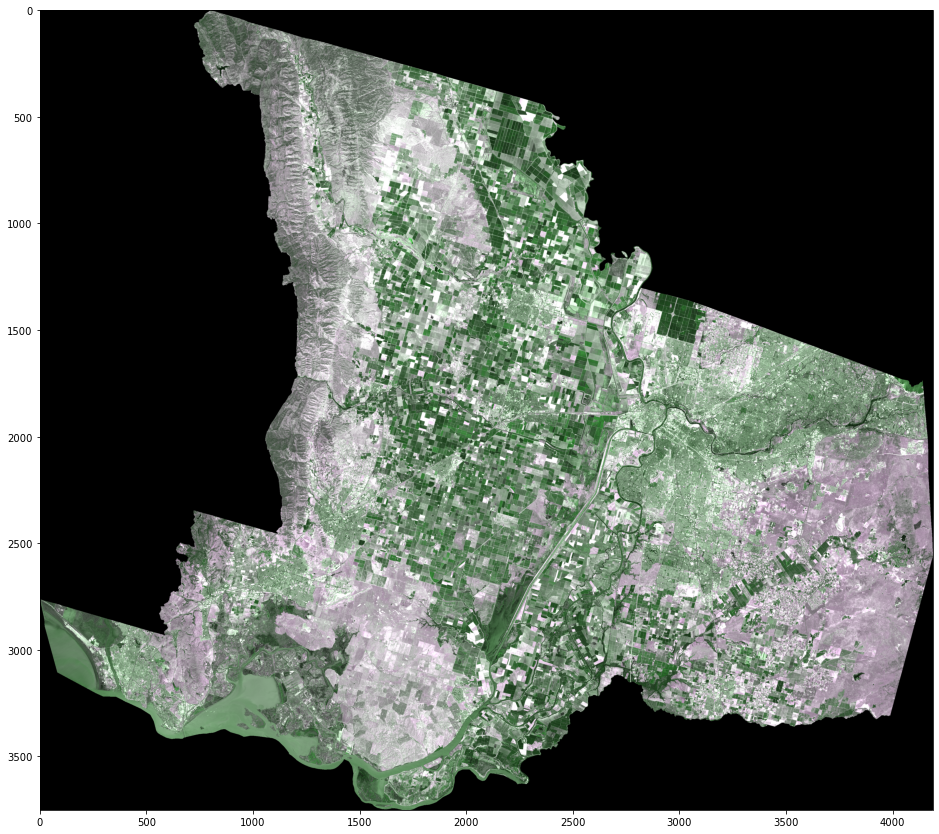

(3751, 4188, 7)
(7, 4188, 3751)
(15709188, 7)


In [3]:
raster_dir = '../data/Data'

for file in os.listdir(raster_dir):
    if file.endswith('SRB1_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        CAerosol = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB2_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        BLUE = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB3_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        GREEN = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB4_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        RED = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB5_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        NIR = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB6_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR1 = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB7_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR2 = raster.GetRasterBand(1).ReadAsArray()

raster_array = np.dstack((CAerosol, BLUE, GREEN, RED, NIR, SWIR1, SWIR2))/10000
Image_Pre_Check = np.dstack((scaleCCMinMax(raster_array[:, :, 3]), scaleCCMinMax(raster_array[:, :, 2]), scaleCCMinMax(raster_array[:, :, 3])))
plt.figure(figsize=(16, 16))
plt.imshow(Image_Pre_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection=raster.GetProjection())
# ax.imshow(Image_Pre_Check)
# plt.show()

print(raster_array.shape)

raster_array_t = raster_array.transpose()
print(raster_array_t.shape)

raster_array_table = raster_array_t.reshape(raster_array_t.shape[0], (raster_array_t.shape[1]*raster_array_t.shape[2])).transpose()
print(raster_array_table.shape)

### Prepare Training label

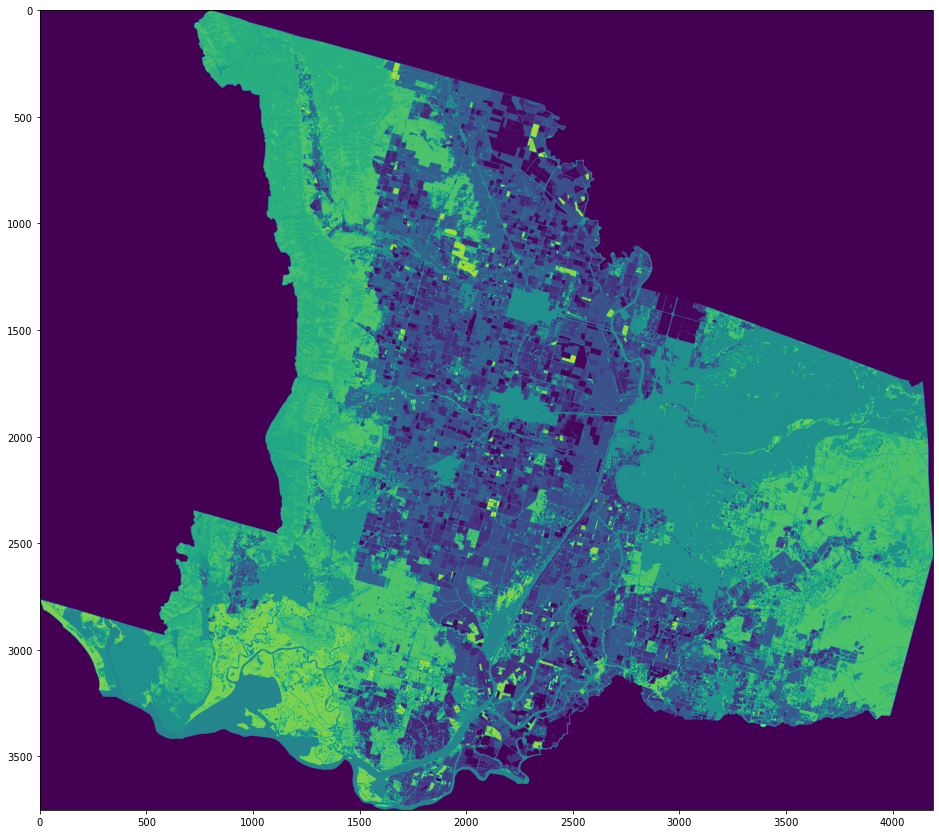

(3751, 4188)
(15709188, 1)


In [4]:
groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'

raster = gdal.Open(groundTruth_path)
groundTruth = raster.GetRasterBand(1).ReadAsArray()

plt.figure(figsize=(16, 16))
plt.imshow(groundTruth)
plt.show()

print(groundTruth.shape)

groundTruth_table = groundTruth.reshape(1, (groundTruth.shape[0]*groundTruth.shape[1])).transpose()
print(groundTruth_table.shape)

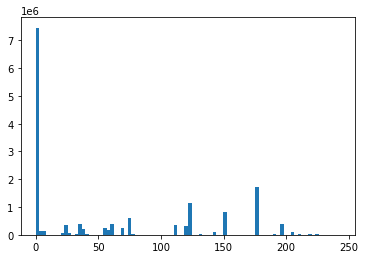

In [5]:
plt.figure()
plt.hist(groundTruth.flatten(), bins = 86)
plt.show()

In [23]:
print(np.unique(groundTruth.flatten()))
print(len(np.unique(groundTruth.flatten())))

[  0   1   2   3   4   5   6  12  13  21  22  23  24  27  28  29  31  33
  36  37  39  42  43  44  46  47  48  49  50  51  53  54  57  58  59  61
  66  67  68  69  70  71  72  74  75  76  77  92 111 112 121 122 123 124
 131 141 142 143 152 176 190 195 204 205 206 208 209 211 212 213 214 216
 217 219 220 221 222 224 225 226 227 228 229 236 242 243]
86


In [28]:
groundTruth_df = pd.DataFrame(groundTruth_table)
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

table['groundType'] = ['Background', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'unflower', 'Sweet Corn', 'Pop or Orn Corn', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Rye', 'Oats', 'Millet', 'Canola', 'Safflower', 'Alfalfa', 
                       'Other Hay/Non Alfalfa', 'Buckwheat', 'Sugarbeets', 'Botatoes', 'Other Crops', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Peas', 'Tomatoes', 'Herbs', 'Clover/Wildflowers', 
                       'Sod/grass Seed', 'Fllow/Idle Cropland', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 
                       'Developed/Open Space', 'Developed/Low Intensity', 'Developed/Med Intensity', 'Developed/High Intensity', 'Barren', 'Decodipis Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland', 'Grassland/Pasture', 'Woody Wetlands', 
                       'Herbaceous Wetlands', 'Pistachios', 'Triticale', 'Carrots', 'Garlic', 'Cantaloupes', 'Olives', 'Oranges', 'Honeydew Meions', 'Broccoli', 'Peppers', 'Pomegranates', 'Greens', 'Plums', 'Strawberries', 'Squash', 'Vetch', 
                       'Dbl Crop WinWht/Corn', 'Dbi Crop Oats/Corn', 'Lettuce', 'Dbl Crop Triticale/Corn', 'Pumpkins', 'Dbl Crop Winwht/Sorghum', 'Blueberries', 'Cabbage']
table['reclassify'] = ['Background', 'Corn', 'Other Crops', 'Rice', 'Wheat', 'GroundVege', 'Flower', 'Corn', 'Corn', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Flower', 'Flower', 'Alfalfa', 'Hay', 'Wheat', 'Tuber', 'Tuber', 'Other Crops', 'Tuber', 
                       'Other Crops', 'GroundVege', 'GroundVege', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege', 'Alfalfa', 'Flower', 'Grassland', 'Idle cropland', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'Grapes', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'NutTree', 
                       'NutTree', 'NutTree', 'FruitsTree', 'Water', 'Water', 'Water', 'Urban', 'Urban', 'Urban', 'Urban', 'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Grassland', 'Wetland', 'Wetland', 'NutTree', 'Wheat', 'GroundVege', 'GroundVege', 'GroundVege', 
                       'NutTree', 'FruitsTree', 'GroundVege', 'GroundVege', 'GroundVege', 'FruitsTree', 'GroundVege', 'FruitsTree', 'Other Crops', 'GroundVege', 'Flower', 'Corn', 'Corn', 'GroundVege', 'Corn', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege']
table['NewValue'] = [0, 18, 20, 17, 16, 12, 15, 18, 18, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 6, 16, 13, 13, 20, 13, 20, 12, 12, 12, 16, 12, 12, 14, 15, 5, 19, 10, 10, 10, 9, 10, 10, 10, 11, 11, 11, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 11, 16, 
                     12, 12, 12, 11, 10, 12, 12, 12, 10, 12, 10, 20, 12, 15, 18, 18, 12, 18, 12, 16, 12, 12]

table.to_csv('../data/GroundTruth/LandCover.csv')
table

0               groundType   reclassify  NewValue
0                                                           
0    7342231               Background   Background         0
1     114438                     Corn         Corn        18
2        467                   Cotton  Other Crops        20
3     140653                     Rice         Rice        17
4       1994                  Sorghum        Wheat        16
..       ...                      ...          ...       ...
228     4151  Dbl Crop Triticale/Corn         Corn        18
229      382                 Pumpkins   GroundVege        12
236      985  Dbl Crop Winwht/Sorghum        Wheat        16
242        2              Blueberries   GroundVege        12
243       77                  Cabbage   GroundVege        12

[86 rows x 4 columns]

In [29]:
for index, row in table.iterrows():
    # print(groundTruth_table == index)
    groundTruth_table[groundTruth_table == index] = row['NewValue']

(15709188, 1)
(3751, 4188)


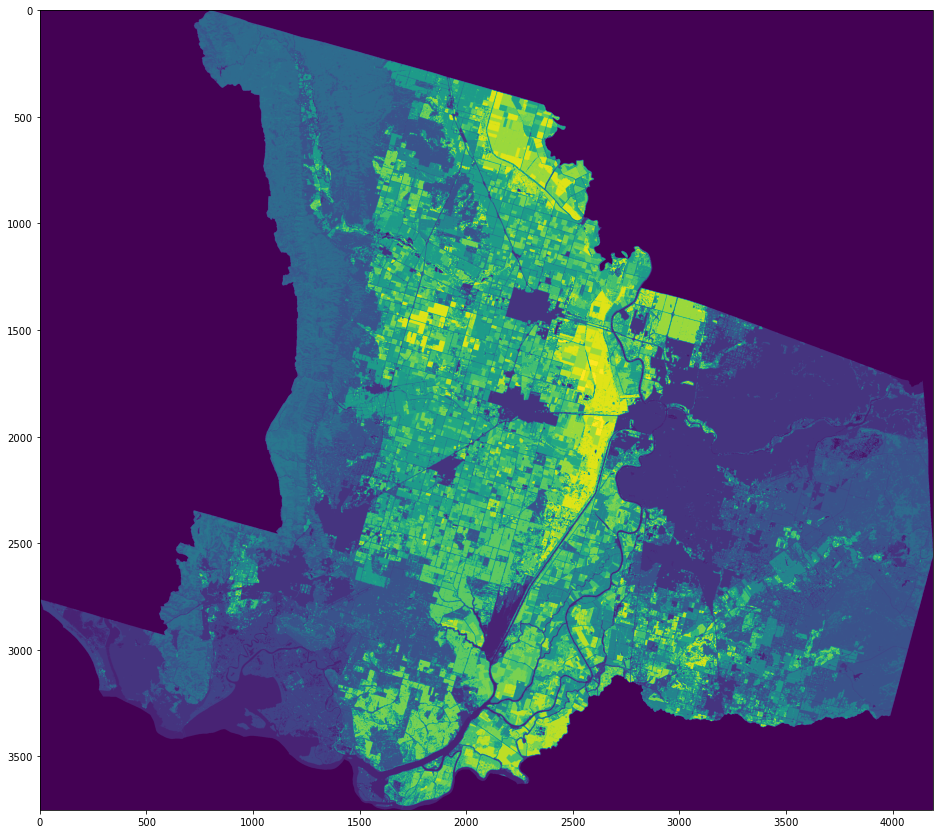

In [30]:
prediction_table = groundTruth_table
print(prediction_table.shape)

prediction = prediction_table.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction.shape)

plt.figure(figsize=(16, 16))
plt.imshow(prediction)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

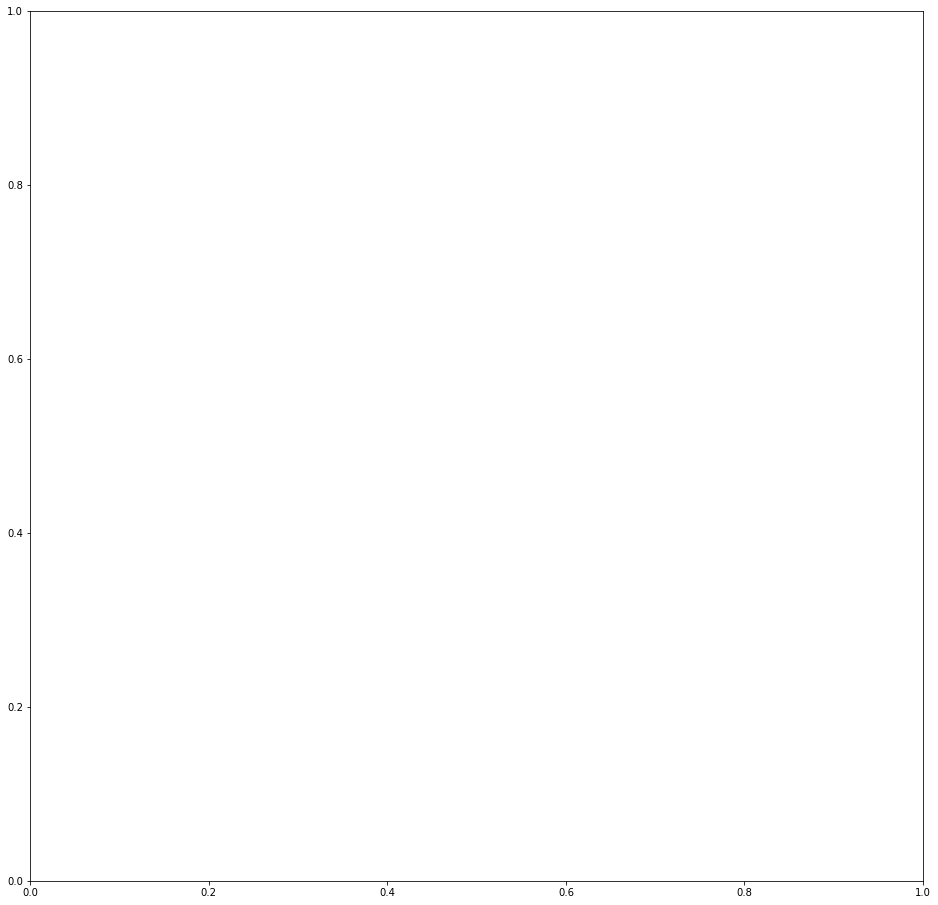

In [38]:
class_labels = ['Background', 'Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']
colors = ['black', 'brown', 'blue', 'purple', 'cyan', 'lime', 'gold', 'green', 'forestgreen', 'seagreen', 'limegreen', 'lawngreen', 'yellowgreen', 'goldenrod', 'springgreen', 'red', 'oragne', 'tomato', 'darkorange', 'peru', 'grey']

cmap = ListedColormap(colors)

class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]
norm = BoundaryNorm(class_bins, len(colors))

xr.DataArray(prediction, coords=da.coords, dims=da.dims, attrs=da.attrs)

f, ax = plt.subplots(figsize=(16, 16))
im = prediction.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# ep.draw_legend(im, titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

### Apply Machine Learning Method

In [9]:
result_array_table = raster_array_table

### Convert prediction back to raster and visual check

(7, 4188, 3751)
(3751, 4188, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


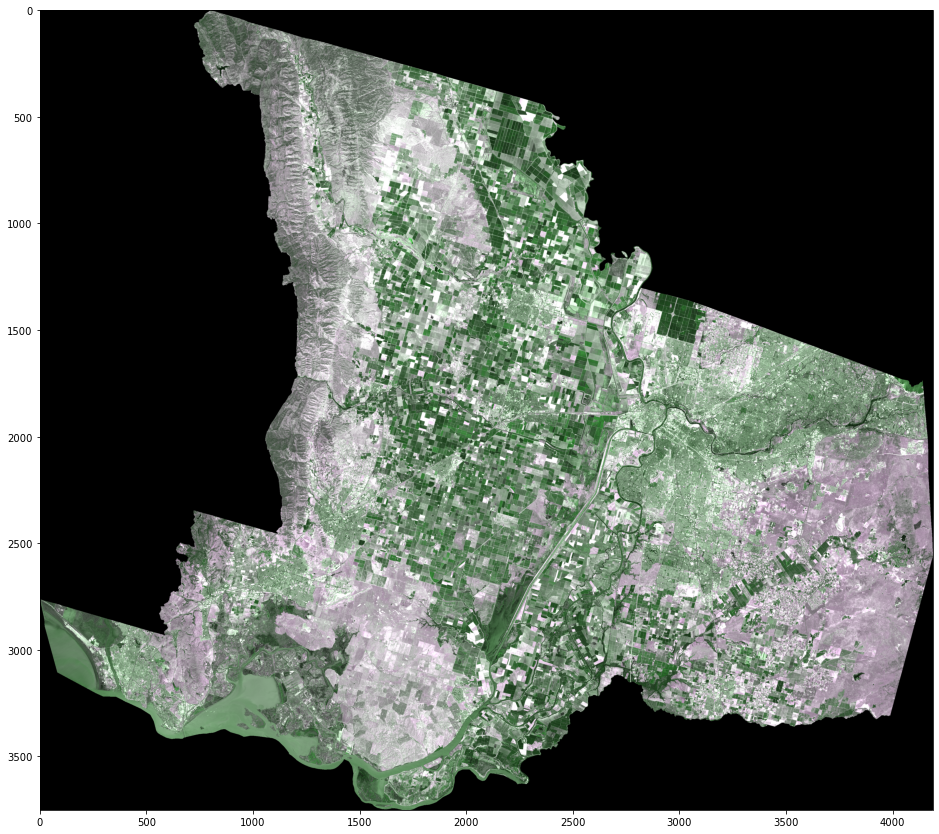

In [10]:
result_array_t = result_array_table.reshape(raster_array_t.shape[0], raster_array_t.shape[1], raster_array_t.shape[2])
print(result_array_t.shape)

result_array = result_array_t.transpose()
print(result_array.shape)

Result_Check = np.dstack((scaleCCMinMax(result_array[:, :, 3]), scaleCCMinMax(result_array[:, :, 2]), scaleCCMinMax(result_array[:, :, 3])))

plt.figure(figsize=(16, 16))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()